# Sentiment Analysis using ULMFiT approach
> Implementing and decoding the revolutionary [ULMFiT](https://arxiv.org/abs/1801.06146) approach to fine-tune a language model on a sentiment analysis task.

---

In [1]:
# Installing and importing the necessary libraries 
# !pip install fastai2 --quiet
# !pip install kaggle --quiet

from fastai2.text.all import *

import warnings
warnings.filterwarnings('ignore')

---

## Dataset Download and  basic EDA
> Using Kaggle API to download the competition dataset and view the data

We'll be using the [Twitter Airlines Tweets](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv) dataset from Kaggle to build the Sentiment classifier.

In [3]:
# Using the kaggle api to search the name of the dataset to download
!kaggle datasets list -s 'twitter airlines'

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
giovamata/airlinedelaycauses                                Airlines Delay                                    67MB  2019-11-14 06:17:27          13461        176  0.64705884       
crowdflower/twitter-airline-sentiment                       Twitter US Airline Sentiment                       3MB  2019-10-16 00:04:05          41619        599  0.8235294        
semihyilmaz/turkish-airlines-daily-stock-prices-since-2013  Turkish Airlines daily stock prices since 2013    22KB  2019-06-20 14:28:03            349         14  1.0              
ternaryrealm/airlines-passenger-data                        Airlines Passenger Data            

The dataset we would like to download is the 2nd one titled `crowdflower/twitter-airline-sentiment`

In [14]:
path = '/home/harish3110/Desktop/airline_tweets_sentiment_analysis/'
dataset = 'crowdflower/twitter-airline-sentiment'
dataset_name = 'twitter-airline-sentiment'

In [15]:
# Creating a folder for the dataset
!mkdir {path + 'data'}
%cd {path + 'data'}

# Using the Kaggle API to download dataset
!kaggle datasets download {dataset}

# Unzip the dataset and delete the respective zip file
!unzip {dataset_name + '.zip'}
!rm {dataset_name + '.zip'} 

%cd {path}

/home/harish3110/Desktop/airline_tweets_sentiment_analysis/data
 78%|█████████████████████████████▊        | 2.00M/2.55M [00:00<00:00, 2.91MB/s]
100%|██████████████████████████████████████| 2.55M/2.55M [00:00<00:00, 4.25MB/s]
Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         
/home/harish3110/Desktop/airline_tweets_sentiment_analysis


In [19]:
path = Path(path)
Path.BASE_PATH = path
(path/'data').ls()

(#2) [Path('data/database.sqlite'),Path('data/Tweets.csv')]

In [20]:
df = pd.read_csv(path/'data/Tweets.csv')

df.head() 

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [21]:
# Viewing distribution of sentiments in dataset
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [23]:
print(f'The dataset corpus set has {len(df)} tweets.')

The dataset corpus set has 14640 tweets.


---

## The ULMFiT approach

The Universal Language Model Fine-tuning (ULMFiT) is an inductive transfer learning approach developed by Jeremy Howard and Sebastian Ruder to all the tasks in the domain of natural language processing which sparked the usage of transfer learning in NLP tasks. 

**The ULMFiT approach to training NLP models is heralded as the ImageNet moment in the domain of Natural Language Processing** 

The model architecture used in the entire process of the ULMFiT approach is ubiquitous and is the well-known **AWD-LSTM** architecture. 

The ULMFiT approach can be braodly explained in the 3 major steps as shown below:

![](https://miro.medium.com/max/2000/1*9n9yv4EalUn76yP1Yffhfw.png 'The ULMFiT Process')

---

### Step 1: Training a general corpus language model

A language model is first trained on a corpus of Wikipedia articles known as Wikitext-103 using a **self-supervised approach**, i.e. using the training labels in itself to train models, in this case training a LM to learn to predict the next word in a sequence. This resulting LM learns the semantics of the english language and captures general features in the different layers. 

This pretrained language model is trained on 28,595 Wikipedia articles and training process is very expensive and time consuming and is luckily open-sourced in the Fastai library for us to use. 

---

### Side Note: Text Pre-processing
>Transforming and normalizing texts such that it can be trained on a neural network for language modeling

Similar to image models where all images used for training the image classifier model are resized to the same dimensions in order to be able to collate them correctly in the GPU, text models also needds to be pre-processed to ensure that we can train a NN model on them. 

Whether it's the articles in the Wikipedia 103 dataset or tweets in airline dataset are of different lengths and can be very long. Thus the tweets corpus i.e. the dataset needs to pre-processed correctly in order to train a neural network on text data. 

There are many ways the pre-processing for textual data can be done and Fastai approach is to apply the following 2 main transforms to texts:

---
***Note:*** A transform in Fastai is basically an **almost** reversible function that transforms data into another form(encoding) and also has the capability of getting back the original data(decoding) if needed. 

---

##### 1. Tokenization

The first step is to gather all the unique `tokens` in the corpus being used. 

A `token` can be defined in numerous ways depedning on the person creating the language model based on the granularity level i.e. the smallest part of the text they would like to consider. In the simplest scenario, a word can be considered as the token.

So the idea is to get a list of all the unique words used in the general domain corpus(Wikipedia 103 dataset) and our added downstream dataset(airline tweets dataset) to build a vocabulary for training our language model.

In [26]:
# Let's take an example text from our training set to show a tokenization example

txt = df['text'].iloc[0]
txt

'@VirginAmerica What @dhepburn said.'

In [27]:
# Initializing the default tokenizer used in Fastai which is that of Spacy called `WordTokenizer`
spacy = WordTokenizer() 

# Wrapping the Spacy tokenizer with a custom Fastai function to make some custom changes to the tokenizer
tkn = Tokenizer(spacy) 

tkn(txt)

(#7) ['xxbos','@virginamerica','xxmaj','what','@dhepburn','said','.']

In [28]:
txts = L([i for i in df['text']])

In [29]:
# Setting up a tokenizer on the entire dataframe 'train'
tok = Tokenizer.from_df(df)
tok.setup(df)

toks = txts.map(tok)
toks[0]

(#7) ['xxbos','@virginamerica','xxmaj','what','@dhepburn','said','.']

---
**Note:** The special tokens you can see above starting with 'xx' are special fastai tokens added on top of the spacy tokenizer used to indicate certain extra meanings in the text data as follows:

- `xxbos`:: Indicates the beginning of a text (here, a review)
- `xxmaj`:: Indicates the next word begins with a capital (since we lowercased everything)
- `xxunk`:: Indicates the next word is unknown

---

As mentioned above `Tokenizer` is a Fastai transform, which is basically a function with and `encodes` and `decodes` method available to tokenize a text and return it back to **almost** the same initial state.

In [30]:
tok.decode(toks[0])

'xxbos @virginamerica xxmaj what @dhepburn said .'

The reason we don't get the original string back when applying `decode` is because the default tokenizer used in this case isn't `reversible`. 

##### 2. Numericalization

The next step in the pre-processing step is to index the tokens created earlier so that they can easily accessed. 

In [31]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([  2, 105,   8,  72,   0, 251,   9])

In [32]:
num.encodes(toks[0])

TensorText([  2, 105,   8,  72,   0, 251,   9])

In [33]:
num.decode(nums[0][:10])

(#7) ['xxbos','@virginamerica','xxmaj','what','xxunk','said','.']

---

### Step 2: Fine-tuning pretrained LM to downstream dataset

Despite having a vast language model pre-trained, it's always likely that the specific downstream task we would like to build our NLP model is a part of a slightly different distribution and thus  need to fine-tune this Wikitext 103 LM.

This step is much faster and it converges much faster as there will be an overlap to the general domain dataset. It only needs to adapt to the idiosyncrasies of the language used and not learn the language per say. 

Since NLP models are more shallow in comparison to a computer vision model, the fine-tuning approaches need to be different and thus the paper provides novel fine-tuning techniques to do so:

#### Discriminative Fine-tuning

Since different layers of the model capture different types of information and thus they should be fine-tuned to different extents. 

This idea is similar as the use of discriminative learning rates used in CV applications which I explained in detail in my previous [post](https://harish3110.github.io/through-tinted-lenses/image%20classification/2020/04/10/Improving-baseline-model.html#Discriminative-learning-rates).

#### Slanted Triangular Learning Rates

The idea behind slanted learning rates is that for a pretrained language model to adpat/fine-tune itself to the downstream dataset, the fine-tuning process should ideally converge faster to asuitable region in the parameter space and thern refine its parameters there. 

So the slanted learning rates approach first linearly increases the learning rates for a short period and then linearly decays the learning rate slowly which is a modification of of Leslie Smith's traingular learning rate approache where the increase and decrease is almost the same. 

![](https://miro.medium.com/max/1096/1*QptmUluWXteT6oI5bD22rw.png 'Slanted Triangular Learning Rates')

#### Creating a dataloader
> Putting the pre-processed data in batches of text sequences for fine-tuning the language model

In [34]:
# dataset for fine-tuning language model which only needs the text data

df_lm = df[['text']].copy()
df_lm.head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials to the experience... tacky.
2,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,@VirginAmerica and it's a really big bad thing about it


---
***Note:*** An important trick used in creating a dataloader here is that we use all the data available to us i.e train and test data. In case we had a dataset with unlabeled reviews we could also use that to fine-tune the pre-trained model better since this step doesn't need labels and is self-supervised. 

---

Creating a dataloader for self-supervised learning task which tries to predict the next word in a sequence as represented by `text_` below. 

**Fastai handles text processing steps like tokenization and numericalization internally when `TextBlock` is passed to `DataBlock`.**

In [35]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

In [36]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

---
***Note:***

- Select the batch size `bs` based on how much your GPU can handle without running out of memory
- The sequence length `seq_len` for the data split used here is the default sequence length used for training the Wikipedia 103 language model

---

In [37]:
dls_lm.show_batch(max_n=3)

,text,text_
0,xxbos @usairways an already pleasant flight from xxmaj london to xxmaj charlotte ( xxunk ) was made fantastic by an amazing attendant . xxmaj thank you so much xxmaj xxunk ! xxbos @southwestair when is the last chance to get # destinationdragons tickets ? i would die of happiness if i won 😭 🙏 xxbos @americanair my flt is at xxunk tom . i have now xxunk notification that xxmaj i 'm,@usairways an already pleasant flight from xxmaj london to xxmaj charlotte ( xxunk ) was made fantastic by an amazing attendant . xxmaj thank you so much xxmaj xxunk ! xxbos @southwestair when is the last chance to get # destinationdragons tickets ? i would die of happiness if i won 😭 🙏 xxbos @americanair my flt is at xxunk tom . i have now xxunk notification that xxmaj i 'm going
1,"xxunk xxbos @united dm'ed you xxbos @virginamerica xxunk , luv xxmaj virgin xxmaj america . xxmaj xxunk xxbos @united how can you never got a flight from austin to xxmaj houston in time for a connection ever ? xxmaj ever ! xxbos @usairways but only for certain flights from xxup clt - nyc . xxmaj the xxunk that you ca n't rebook customers for 48 hours is absurd . xxbos @southwestair xxunk","xxbos @united dm'ed you xxbos @virginamerica xxunk , luv xxmaj virgin xxmaj america . xxmaj xxunk xxbos @united how can you never got a flight from austin to xxmaj houston in time for a connection ever ? xxmaj ever ! xxbos @usairways but only for certain flights from xxup clt - nyc . xxmaj the xxunk that you ca n't rebook customers for 48 hours is absurd . xxbos @southwestair xxunk party"
2,springs . xxmaj long day starting at a snowy xxunk am in philly . xxbos @americanair i fly xxunk with you and have n't seen one xxbos @usairways xxup ur service is so shitty . xxmaj pilot never showed up so we waited hours because another pilot was supposed to come but did n't # xxmaj cancelled xxmaj flighted xxbos @jetblue xxunk on a xxunk still a xxunk . xxmaj ur new,. xxmaj long day starting at a snowy xxunk am in philly . xxbos @americanair i fly xxunk with you and have n't seen one xxbos @usairways xxup ur service is so shitty . xxmaj pilot never showed up so we waited hours because another pilot was supposed to come but did n't # xxmaj cancelled xxmaj flighted xxbos @jetblue xxunk on a xxunk still a xxunk . xxmaj ur new baggage


In [38]:
# Saving the dataloader for fast use in the future

torch.save(dls_lm, path/'airlines_tweets_dls_lm.pkl')

In [39]:
# To load the Dataloaders in the future

dls_lm = torch.load(path/'airlines_tweets_dls_lm.pkl')

---
#### Fine-tuning the language model

Fine-tuning Wikitext 103 based LM to airline tweets using ULMFiT fine-tuning methodologies. This fine-tuned LM can thus be used as the base to classify airline texts in the next step.

The common metric used in CV models is accuracy but in sequence based models we use something called **perplexity** which is basically exponential of the loss as follows:

```
torch.exp(cross_entropy)
```

In [40]:
#fine-tuning wikitext LM to airline tweets dataset

learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [41]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(4696, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(4696, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4696, bias=True)
    (output_dp): RNNDropout()
  )
)

---
##### Embedding Layer

We can see that the above `AWD LSTM` architecture used in ULMFiT has a bunch of layers called **embedding** layers as the input here.

The pre-processed text and the batching of data using dataloaders is followed by passing this data into an embedding layer which can be considered as a small neural network by itself which is used to calculate token i.e. word dependencies in the dataset. These layers are trained along with the main neural network model and learns relationships between words in the dataset along the way. 

An embedding layer is a computationally efficient method to represent tokens in a lesser dimension space, being less sparse and as a look-up table for all tokens in our dataset which captures relationships between the tokens. 

It's a much more computationally efficient approach to the traditional `one-hot encoding` appraoch which can make these types of task really expensive and inefficient.

![](https://www.fast.ai/images/kittenavalanche.png "In the above embediing layer learned, vectors for baby animal words are closer together, and an unrelated word like 'avalanche' is further away")

If you would like to know more about word embedding check out this amazing [video](https://www.youtube.com/watch?v=25nC0n9ERq4) by Rachael Thomas, co-founder of Fastai.

---

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.04786301031708717)

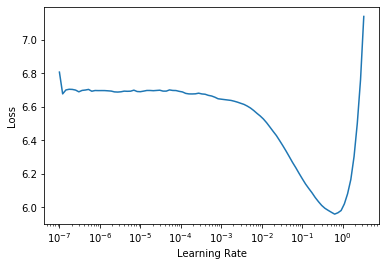

In [42]:
learn.lr_find()

Let's train the last layer of the model using a learning rate of `2e-2` based on the above learning rate finder plot using Leslie Smith's [1 Cycle Training](https://arxiv.org/abs/1708.07120) approach.

In [43]:
learn.fine_tune(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.072490,4.019218,0.254360,55.657562,00:10


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.152642,3.818886,0.277433,45.553436,00:10
1,3.984446,3.701912,0.291295,40.524731,00:10
2,3.816209,3.644717,0.295096,38.271938,00:10
3,3.690142,3.617772,0.300390,37.254467,00:10
4,3.608074,3.615940,0.301382,37.186298,00:10


Once we have fine-tuned out LM to our downstream task, we save the `encoder` part of the model which portion of the model except the final layer that predicts the next word in the sequence. 

We can then use this`encoder` part, which is the portion that learns the language semantics, as our base to build an airline tweets classification model. 

In [44]:
# Saving the encoder

learn.save_encoder('finetuned')

---

### Step 3: Training a classifier on the downstream NLP task

Now that we have a language model fine-tuned to our downstream NLP dataset we can use the encoder portion of the fine-tuned language model which is the part that learns the features of the language used in the downstream dataset as the base to build a text classifier for tasks such as sentiment analysis, spam detection, fraud detection, document classifcation etc. 

The encoder saved is then appended by a simple classifier consisting of two additional linear blocks consisting of the  standard batch normalization and dropout, with ReLU activations for the intermediate layer and a softmax activation at the last layer for the classification purpose. 

Fine-tuning a classifier is a very critical task in a transfer learning method and is the main reason why transfer learning approaches failed until ULMFiT came along. 

Overly aggressive fine-tuning can result in **catastrophic forgetting** and too cautious fine-tuning can lead to extremely slow convergence. 

To tackle this problem, ULMFiT introduces a novel fine-tuning technique in **gradual unfreezing** besides also using **slanted triangular learning rates** and **discriminative fine-tuning** to successfully train a classifier using a pre-trained LM.

#### Gradual Unfreezing

The idea behind gradual unfreezing is that fine-tuning a classifier on all layers can result in catastrophic forgetting and thus each layer staring form the las layer is trained one after the other by freezing all the lower layers and only training the layer in question. 

The paper empirically found that after training the last layer of the model with a learning rate of `lr`, the subsequent layers can be trained one after another by reducing `lr` by a factor of `2.6`.

#### Backpropagation Throught Time for Text Classification (BPT3C)

Since the model architecture for training and fine-tuning the language is that of an LSTM, the paper implements the backpropagation through time(BPTT) approach to be able propagate gradients without them exploding or vanishing. 

In the ULMFiT approach, a modification to the traditional BPTT is made specifically in the fine-tuning classifier phase called **BPTT for Text Classification(BPT3C)** to make fine-tuning a classifier for large documents feasible. 

Steps in BPT3C:
- The document is divided into fixed length batches of size 'b'. 
- At the beginning of each batch, the model is initiated with the final state of the previous batch by keeping track of the hidden states for mean and max-pooling. 
- The gradients are back-propagated to the batches whose hidden states contributed to the final prediction. 
- In practice, variable length back-propagation sequences are used. 


#### Concat Pooling

Since signals for classifying texts can exist anywhere and are not only limited to last word in the sequence, the ULMFiT approach also proposes to concatenate the last time step of the document by max-pooling and mean-pooling representations to provide more signal and better training

#### Creating the classifier dataloader

Ensure that the sequence length and vocab passed to the `TextBlock` is same as that given while fine-tuning LM 

In [45]:
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [46]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('text'),
                get_y=ColReader('airline_sentiment'),
                splitter=RandomSplitter(0.2))

In [48]:
dls = dls.dataloaders(df, bs=64)

In [49]:
dls.show_batch(max_n=3)

,text,category
0,xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * xxunk xxmaj what is checked bag allowance for xxup jac - lax ?,neutral
1,"xxbos @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative
2,xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,negative


In [51]:
# Viewing the number of classes for dataloader
dls.c

3

In [53]:
len(dls.train_ds), len(dls.valid_ds)

(11712, 2928)

#### Defining the learner

In [57]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, FBeta(beta=1, average='weighted')]).to_fp16()
learn.load_encoder('finetuned')

In [58]:
#collapse
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(4696, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(4696, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


---
#### Training the classifier
> Fine-tuning a text classifier using gradual unfreezing, slanted learning rates and discriminating learning techniques.

In [59]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.699208,0.511487,0.794399,0.782101,00:03


In [60]:
# Applying gradual unfreezing of one layer after another

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.621459,0.498418,0.809085,0.805459,00:04


In [61]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.545464,0.474213,0.817623,0.806556,00:04


In [62]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),3e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.470213,0.461382,0.820014,0.810007,00:05
1,0.474566,0.471604,0.825820,0.818866,00:05


In [63]:
learn.save('final_model')

---

## Conclusion

In this post we have seen how to build a fine-tuned language model for any textual data corpus which captures the semantics of the dataset. The encoder part of this fine-tuned language model was then used to build a pretty-decent text classifier that can identify airline tweets with a accuarcy of above 82.5%.

---

## References

- Fastai v2 [Documentation](www.dev.fasta.ai)
- Fastbook Chapter 10: [NLP Deep Dive](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb)
- ULMFiT [Paper](https://arxiv.org/abs/1801.06146)

---